<a href="https://colab.research.google.com/github/abdoghareeb46/Speech-Emotion-Recognition/blob/master/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
from google.colab import files
files.upload()

{}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d suso172/arabic-natural-audio-dataset

 99% 556M/560M [00:04<00:00, 127MB/s]
100% 560M/560M [00:04<00:00, 127MB/s]


In [0]:
!ls

arabic-natural-audio-dataset.zip  data	drive  kaggle.json  sample_data


In [0]:
! mkdir data

In [0]:
! unzip arabic-natural-audio-dataset.zip -d data

In [0]:
!pip install SoundFile
!pip install librosa

In [0]:
import numpy as np
import pandas as pd
import librosa # to extract speech features
import glob
import os
import pickle # to save model after training
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report # to measure how good we are
from sklearn.preprocessing import LabelEncoder


In [0]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X,sample_rate=librosa.load(file_name)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result

In [51]:
!ls /content/data/

1sec_segmented_part1  ANAD.csv		     V1.wav  V4.wav  V7.wav
1sec_segmented_part2  ANAD_Normalized.csv    V2.wav  V5.wav  V8.wav
1sec_segmented_part3  caller_Reciever_turns  V3.wav  V6.wav


In [0]:
def load_data():
  data=pd.read_csv("/content/data/ANAD.csv")
  data=data.iloc[:,[0,1]].copy()
  data["name"]=data["name"].apply(lambda x:x.replace("'",""))
  data.columns=["name","emo"]
  files = glob.glob("/content/data/1sec_segmented_part1/1sec_segmented_part1/*.wav")+\
  glob.glob("/content/data/1sec_segmented_part2/1sec_segmented_part2/*.wav")+\
  glob.glob("/content/data/1sec_segmented_part3/1sec_segmented_part3/*.wav")
  names=[f.split("/")[-1] for f in files]
  emo_=[]
  for i in names:
    try:
      emo_.append(data[data["name"]==i]["emo"].values[0])
    except:
      emo_.append(np.nan)
  
  full_data=pd.DataFrame([files,emo_]).T
  full_data.columns=["filePath","labels"]
  full_data.dropna(inplace=True)
  return full_data


def to_features():
  full_data=load_data()
  X=[extract_feature(e, mfcc=True, chroma=True, mel=True,contrast=True) for e in full_data["filePath"].values]
  X=np.array(X)
  print("features shape",X.shape)
  lb=LabelEncoder()
  labels=lb.fit_transform(full_data["labels"])
  X_train, X_test, y_train, y_test=train_test_split(X, labels, test_size=30, random_state=45)
  return  X_train, X_test, y_train, y_test

def model_training():
  X_train, X_test, y_train, y_test=to_features()
  model_params = {
      'alpha': 0.0001,
      'batch_size': 64,
      'epsilon': 1e-08, 
      'hidden_layer_sizes': (512, 256, 128), 
      'learning_rate': 'adaptive', 
      'max_iter': 500}

  model = MLPClassifier(**model_params)
  model.fit(X_train, y_train)
  return model


#### Data

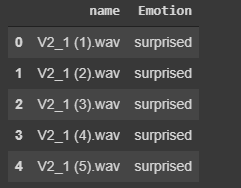

#### Data After adding path for each file name 
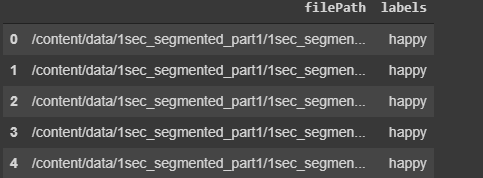

In [59]:
model=model_training()

features shape (1334, 187)


In [60]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
print(f1_score(y_test,y_pred,average=None))

Accuracy: 96.67%
[0.96       1.         0.85714286]
